# DISCLAIMER
The `random_state` is set to 42 because it is a common convention choice in tutorials and assignments (a "fun convention" from *The Hitchhiker's Guide to the Galaxy*). You can pick any integer, but different integers produce different sequence of randomness so your results will not be identical across different seeds. Using a fixed `random_state` ensures reproducibility of results.

# Imports

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import imblearn

from sklearn import tree, preprocessing
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from IPython.display import Image
from pandas.plotting import scatter_matrix


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
!pip install imblearn

### Load wine dataset

In [2]:
#Load wine dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='target')

X.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                          3.92   1065.0  
1                          3.40   1050.0  
2                          3.17   1185.0  
3                          3.45   1480.0  
4                          2.93    735.0

### Define variables 

In [3]:
#Define variables X, Y and df
X=wine.data
Y=wine.target
df=pd.DataFrame(X,columns=wine.feature_names)
df.head()

#changing name of troublesome column
i = wine.feature_names.index('od280/od315_of_diluted_wines')
wine.feature_names[i] = 'ratio_of_diluted_wines'
df = df.rename(columns={'od280/od315_of_diluted_wines': 'ratio_of_diluted_wines'})

# Train a default decision tree

In [4]:
# Split dataset (train/test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

# Train a default decision tree no.1
default_model = DecisionTreeClassifier(random_state=42)
default_model.fit(X_train, Y_train)

# Predict and check accuracy
predictions = default_model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)

**Repeated cross-validation to evaluate generalization across multiple random seeds**

In [5]:
# Split dataset (train/test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

cv_scores = []
for seed in range(5):
    repeated_default_model = DecisionTreeClassifier(random_state=seed)
    scores = cross_val_score(repeated_default_model, X, Y, cv=10)
    cv_scores.append(scores.mean())
    
repeated_default_model.fit(X_train, Y_train)
cv_scores = np.array(cv_scores)

In [6]:
# Save the trained model to disk
import joblib as jb
jb.dump(default_model, 'wine-decision-tree.joblib')

# Load the saved model
default_model = jb.load('wine-decision-tree.joblib')

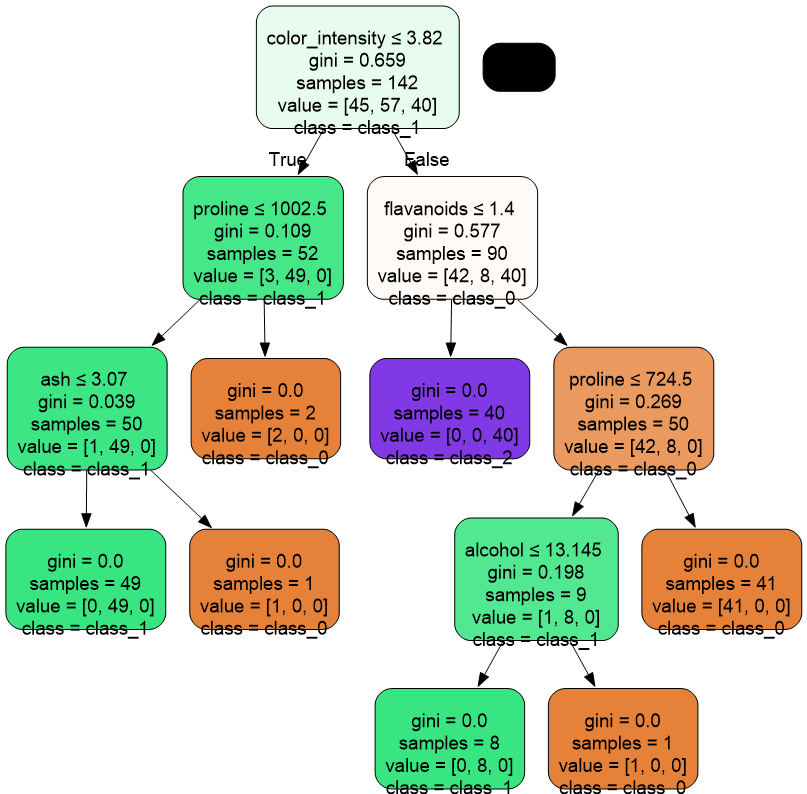

In [7]:
#Plot the tree using Graphviz and Pydotplus
#Make sure you have graphviz installed from https://graphviz.org/download/ otherwise it will not work

dot_data = tree.export_graphviz(
    default_model,
    out_file=None,
    feature_names=wine.feature_names,
    class_names=wine.target_names,
    label='all',
    filled=True,
    rounded=True,
    special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


**QUESTION 1.1:**

In the picture above is the picture of the decision tree of the given dataset.

In [8]:
scores = cross_val_score(default_model, X, y, cv=10)
print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())
print("Test accuracy:", accuracy)

print("REPEATED Cross validation values:\n", cv_scores)
print("REPEATED Cross validation mean:", cv_scores.mean())
print("REPEATED Cross validation standard deviation: ", cv_scores.std())

Cross validation values:
 [0.88888889 0.88888889 0.66666667 0.88888889 0.83333333 0.83333333
 1.         0.94444444 0.94117647 0.76470588]
Cross validation mean: 0.865032679738562
Cross validation standard deviation:  0.0913519991478125
Test accuracy: 0.9444444444444444
REPEATED Cross validation values:
 [0.87058824 0.86503268 0.87614379 0.86503268 0.85947712]
REPEATED Cross validation mean: 0.8672549019607845
REPEATED Cross validation standard deviation:  0.005665577237325262


**QUESTION 1.2:**
The cross-validation (CV) values represent the accuracy of the model on ten different train/split of the dataset. The cross-validation shows how the model performs when trained and tested on different splits of the data (fold), indicating how stable and generalizable  the model is.

The highest score shows the model's best performance on the easiest fold.
The lowest score shows how poorly the model performs on the most difficult fold.
The mean score gives an overall estimate of generalization performance.

A large difference between the highest and lowest fold scores indicates instability, it often appears when the model is too complex and "memorizes" the training data instead of learning patterns, this is behaviour is known as overfitting. In contrast, a high mean score with low variance between folds indicates that the model generalizes well.

In our case, the scores vary noticeably across folds:
- Some folds have very high accuracy, close to 0.9444 or even 1
- Other folds have much lower accuracy, such as 0.66 or 0.76

As a result of this variation, the CV mean is only 0.865 and the standard deviation is relatively high (0.091). Which tell us that our model is sensitive to how the data is split and does not perform consistently across folds.
In contrast, the test accuracy (0.94) is higher than the CV mean because the test accuracy represent performance on only one specific train/test split. Therefore, we can conclude that the test accuracy (0.94) shows that the model performs well on this particular test set and the lower CV mean (0.865) shows that the model does not achieve this high accuracy consistently across data splits, indicating limited stability and some overfitting. 

To ensure the decision tree generalize well, we repeated 10-fold CV five times with different random seeds. The resulting mean CV accuracy across these repeats was 0.867 with a standard deviation of 0.0056. This low standard deviation indicates that the chosen tree architecture consistently performs well across different splits of the data, confirming that the model generalizes beyond a single train/test split.

**QUESTION 1.3:**

What first draws attention is the many single leafs with very little samples each, because that is a very clear example of overfitting. This result makes sense if we think about the value of the standard deviation of the cross validation above.
What is actually good about the tree, that also follows along the cross validation values, are the "gini" values. They suggest that the data is very well classified and the chances of each class being missclassified are very low.

The default decision tree has no depth limit which produces a tree that is too deep and contains many small leaf nodes with very few samples. These leaf nodes appearing deep in the tree indicate overfitting as the tree splitting is based on small dataset-specific variations rather than meaningful or generalizable patterns. When observing the tree structure, the top-level splits use features such as color_intensity, flavanoids and proline which indicates the they have the highest importance. This matches the scatter matrix in assignment 1, where these same features formed clear wine classes seperation. The top three features are dominating and contain strong discriminatory power.

Overall, the tree's large depth, many leaves and large variation in CV scores confirm that the default decision tree does not generalize well.

# Limit the depth of the tree

Cross validation values:
 [0.77777778 0.72222222 0.66666667 0.83333333 0.83333333 0.83333333
 0.83333333 0.94444444 0.94117647 1.        ]
Cross validation mean: 0.838562091503268
Cross validation standard deviation:  0.09730882614969538
Test accuracy: 0.8611111111111112



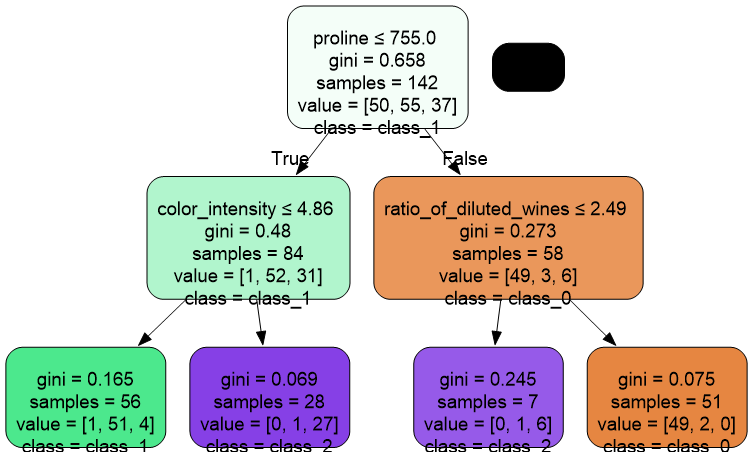

In [9]:
#Limit the depth of the tree
depth_model = DecisionTreeClassifier(max_depth=2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
depth_model.fit(X_train, Y_train)

predictions = depth_model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)
scores = cross_val_score(depth_model, X, Y, cv=10)

print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())
print("Test accuracy:", accuracy)

dot_data = tree.export_graphviz(
    depth_model,
    out_file=None,
    feature_names=wine.feature_names,
    class_names=wine.target_names,
    label='all',
    filled=True,
    rounded=True,
    special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


**QUESTION 1.4**

The image above shows the decision tree with a limited maximum depth as asked.

# Tree parameters tuning - Systematic grid search approach
Here is an systematic approach for tuning the decision tree to find a tree that generalize well across splits of data.

In [10]:
#Possible test values
param_grid = {
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8], 
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8]
}
#Use cross-validation to evaluate all combinations
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=10,
    scoring='accuracy'
)
grid_search.fit(X, Y)

# Best combination of parameters
best_params = grid_search.best_params_
print(best_params)

# Best cross-validation score (mean accuracy)
best_cv_score = grid_search.best_score_
print("Best mean cross-validation accuracy:", best_cv_score)

{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best mean cross-validation accuracy: 0.888888888888889


**Final model of parameter tuning**

Cross validation values:
 [0.94444444 0.88888889 0.66666667 0.83333333 0.83333333 0.77777778
 1.         0.94444444 1.         1.        ]
Cross validation mean: 0.888888888888889
Cross validation standard deviation:  0.10540925533894598
Test accuracy: 0.9722222222222222



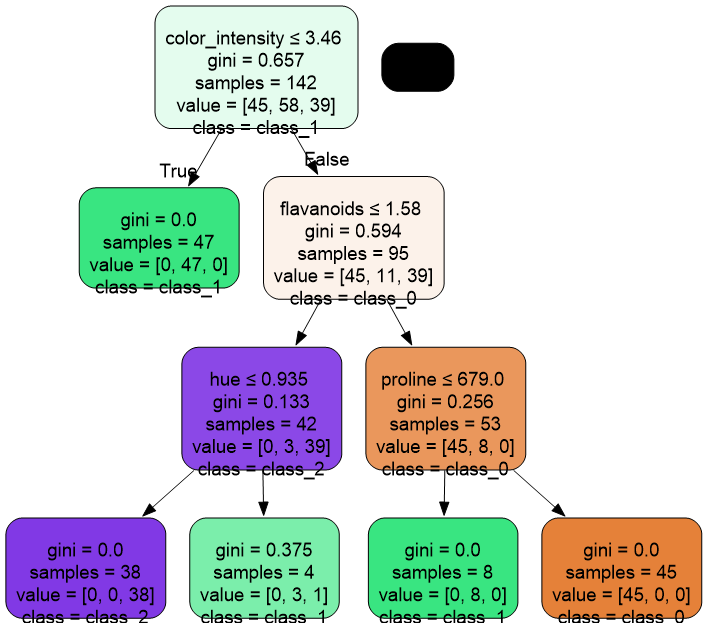

In [11]:
#Question 5: final model - systematic grid search approach
parameter_model = DecisionTreeClassifier(max_depth=4 ,min_samples_split = 2, min_samples_leaf=4,random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
parameter_model.fit(X_train, Y_train)

predictions = parameter_model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)
scores = cross_val_score(parameter_model, X, Y, cv=10)

print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())
print("Test accuracy:", accuracy)

dot_data = tree.export_graphviz(
    parameter_model,
    out_file=None,
    feature_names=wine.feature_names,
    class_names=wine.target_names,
    label='all',
    filled=True,
    rounded=True,
    special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

**Repeated cross-validation to evaluate generalization across multiple random seeds**

In [12]:
#Question 5: final model - systematic grid search approach
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

cv_scores = []
for seed in range(5):
    repeated_parameter_model = DecisionTreeClassifier(max_depth=4 ,min_samples_split = 2, min_samples_leaf=4, random_state=seed)
    scores = cross_val_score(repeated_parameter_model, X, Y, cv=10)
    cv_scores.append(scores.mean())
    
repeated_parameter_model.fit(X_train, Y_train)
cv_scores = np.array(cv_scores)

print("Cross validation values:\n", cv_scores)
print("Cross validation mean:", cv_scores.mean())
print("Cross validation standard deviation: ", cv_scores.std())

Cross validation values:
 [0.89411765 0.88267974 0.87745098 0.87712418 0.88267974]
Cross validation mean: 0.8828104575163399
Cross validation standard deviation:  0.006147266434524201


**QUESTION 1.5**
Above is the systematic grid search over the tree parameters (`max_depth`, `min_samples_leaf`, `min_samples_split`) and the final model for parameter tuning. The grid search showed that the best combination of parameters based on the highest mean CV score was `max_depth=4`, `min_samples_leaf=4`, `min_samples_split=2` with the CV mean 0.888. This searches 7x7x8=392 models and works on smaller datasets such as Wine it's manageable. It prevents tiny leaves and reduces overfitting, giving higher mean CV accuracy. This combination balances bias and variance implying that the tree is not too deep, leaves have sufficient samples and CV that shows good accuracy of  0.888 with reduces standard deviation. The selection of the parameter values are of reasonable range that balances bias and variance and computational efficiency. The grid search finds the combination within this range that achieves the highest cross-validation accuracy.

**QUESTION 2.1:**

As it has been showed above, the standard deviation of the tree is 0.105 and the average is 0.888 and, finally, the accuracy value is 0.972. 

To ensure the decision tree generalize well, we repeated 10-fold CV five times with different random seeds. The resulting mean CV accuracy across these repeats was 0.883 with a standard deviation of 0.0061. This low standard deviation indicates that the chosen tree architecture(`max_depth=4`, `min_samples_leaf=4`, `min_samples_split=2`) consistently performs well across different splits of the data, confirming that the model is robust and generalizes beyond a single train/test split. 

Cross validation values:
 [0.88888889 0.88888889 0.61111111 0.88888889 0.83333333 0.88888889
 1.         0.88888889 0.94117647 0.76470588]
Cross validation mean: 0.8594771241830067
Cross validation standard deviation:  0.10104329956693009
Test accuracy: 0.9166666666666666


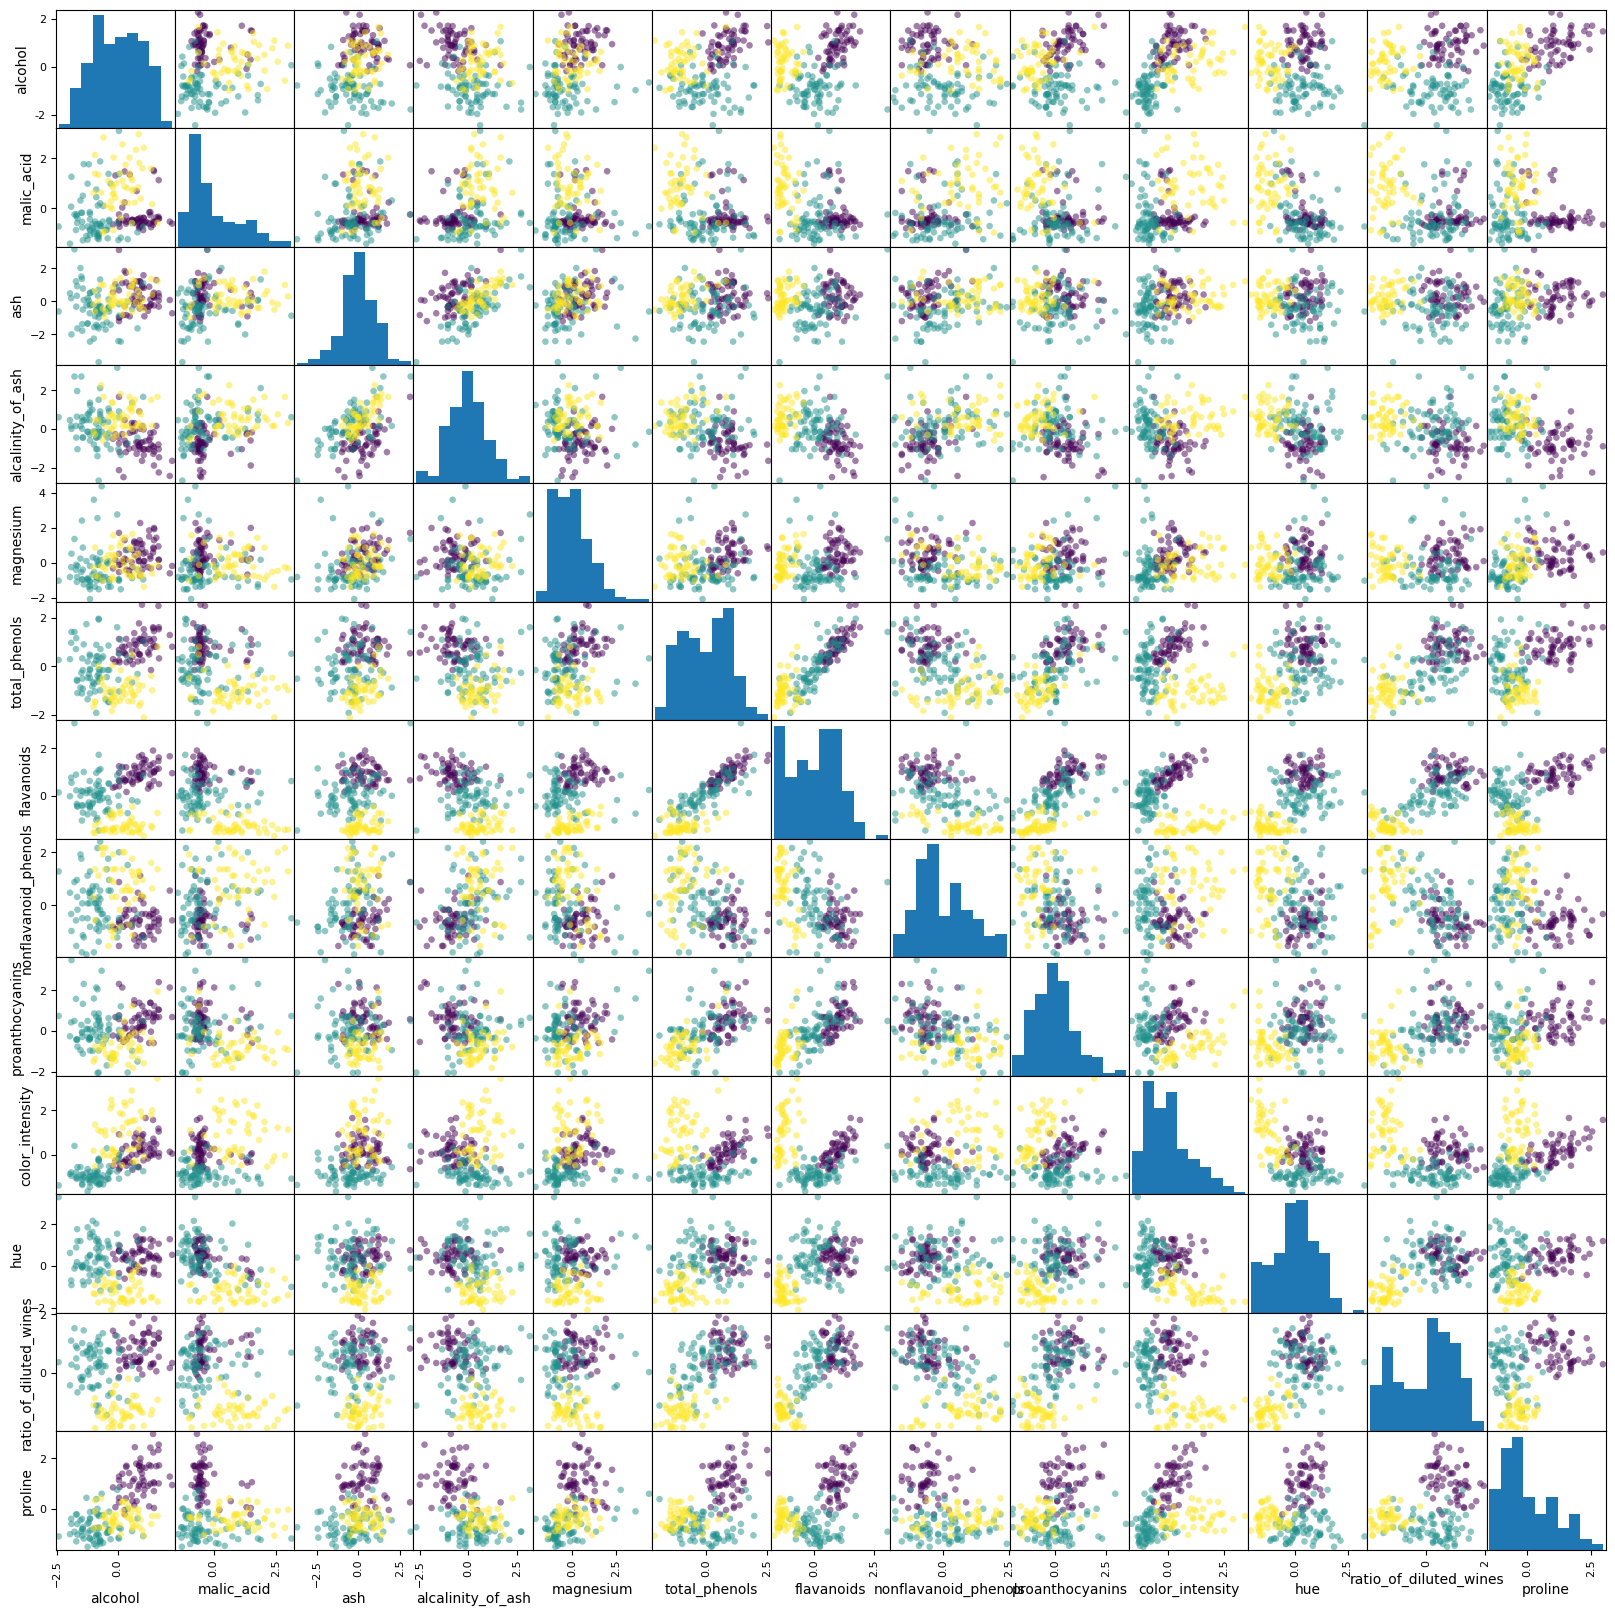

In [13]:
standardized_X = preprocessing.scale(X)
df_std = pd.DataFrame(standardized_X, columns=wine.feature_names)
visual_std = pd.plotting.scatter_matrix(df_std, figsize=(20, 20), c=Y, s=90)

std_model = DecisionTreeClassifier(max_depth=4, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(standardized_X, Y, test_size=0.2)
std_model.fit(X_train, Y_train)

predictions = std_model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)
scores = cross_val_score(std_model, X, Y, cv=10)

print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())
print("Test accuracy:", accuracy)

**Repeated cross-validation to evaluate generalization across multiple random seeds**

In [14]:
standardized_X = preprocessing.scale(X)

X_train, X_test, Y_train, Y_test = train_test_split(standardized_X, Y, test_size=0.2)
cv_scores = []
for seed in range(5):
    repeated_std_model = DecisionTreeClassifier(max_depth=4, random_state=seed)
    scores = cross_val_score(repeated_std_model, X, Y, cv=10)
    cv_scores.append(scores.mean())
    
repeated_std_model.fit(X_train, Y_train)
cv_scores = np.array(cv_scores)

print("Cross validation values:\n", cv_scores)
print("Cross validation mean:", cv_scores.mean())
print("Cross validation standard deviation: ", cv_scores.std())

Cross validation values:
 [0.87614379 0.86470588 0.86503268 0.87614379 0.85947712]
Cross validation mean: 0.8683006535947712
Cross validation standard deviation:  0.006700541898752494


**QUESTION 2.2.1:**

The scatter matrix above shows the data after standardization. Standarization rescales each feature so that it has a mean of 0 and a standard deviation of 1. This is useful when the dataset contains features measured in different units or on very different scales, because it makes all features comparable, so none of them appears importnat just because of bigger numbers. Standardization is especially helpful for models that are affected by differences in feature scale or that work best when the data is roughly normally distributed. 

Cross validation values:
 [0.88888889 0.88888889 0.61111111 0.88888889 0.83333333 0.88888889
 1.         0.88888889 0.94117647 0.76470588]
Cross validation mean: 0.8594771241830067
Cross validation standard deviation:  0.10104329956693009
Test accuracy: 0.8888888888888888


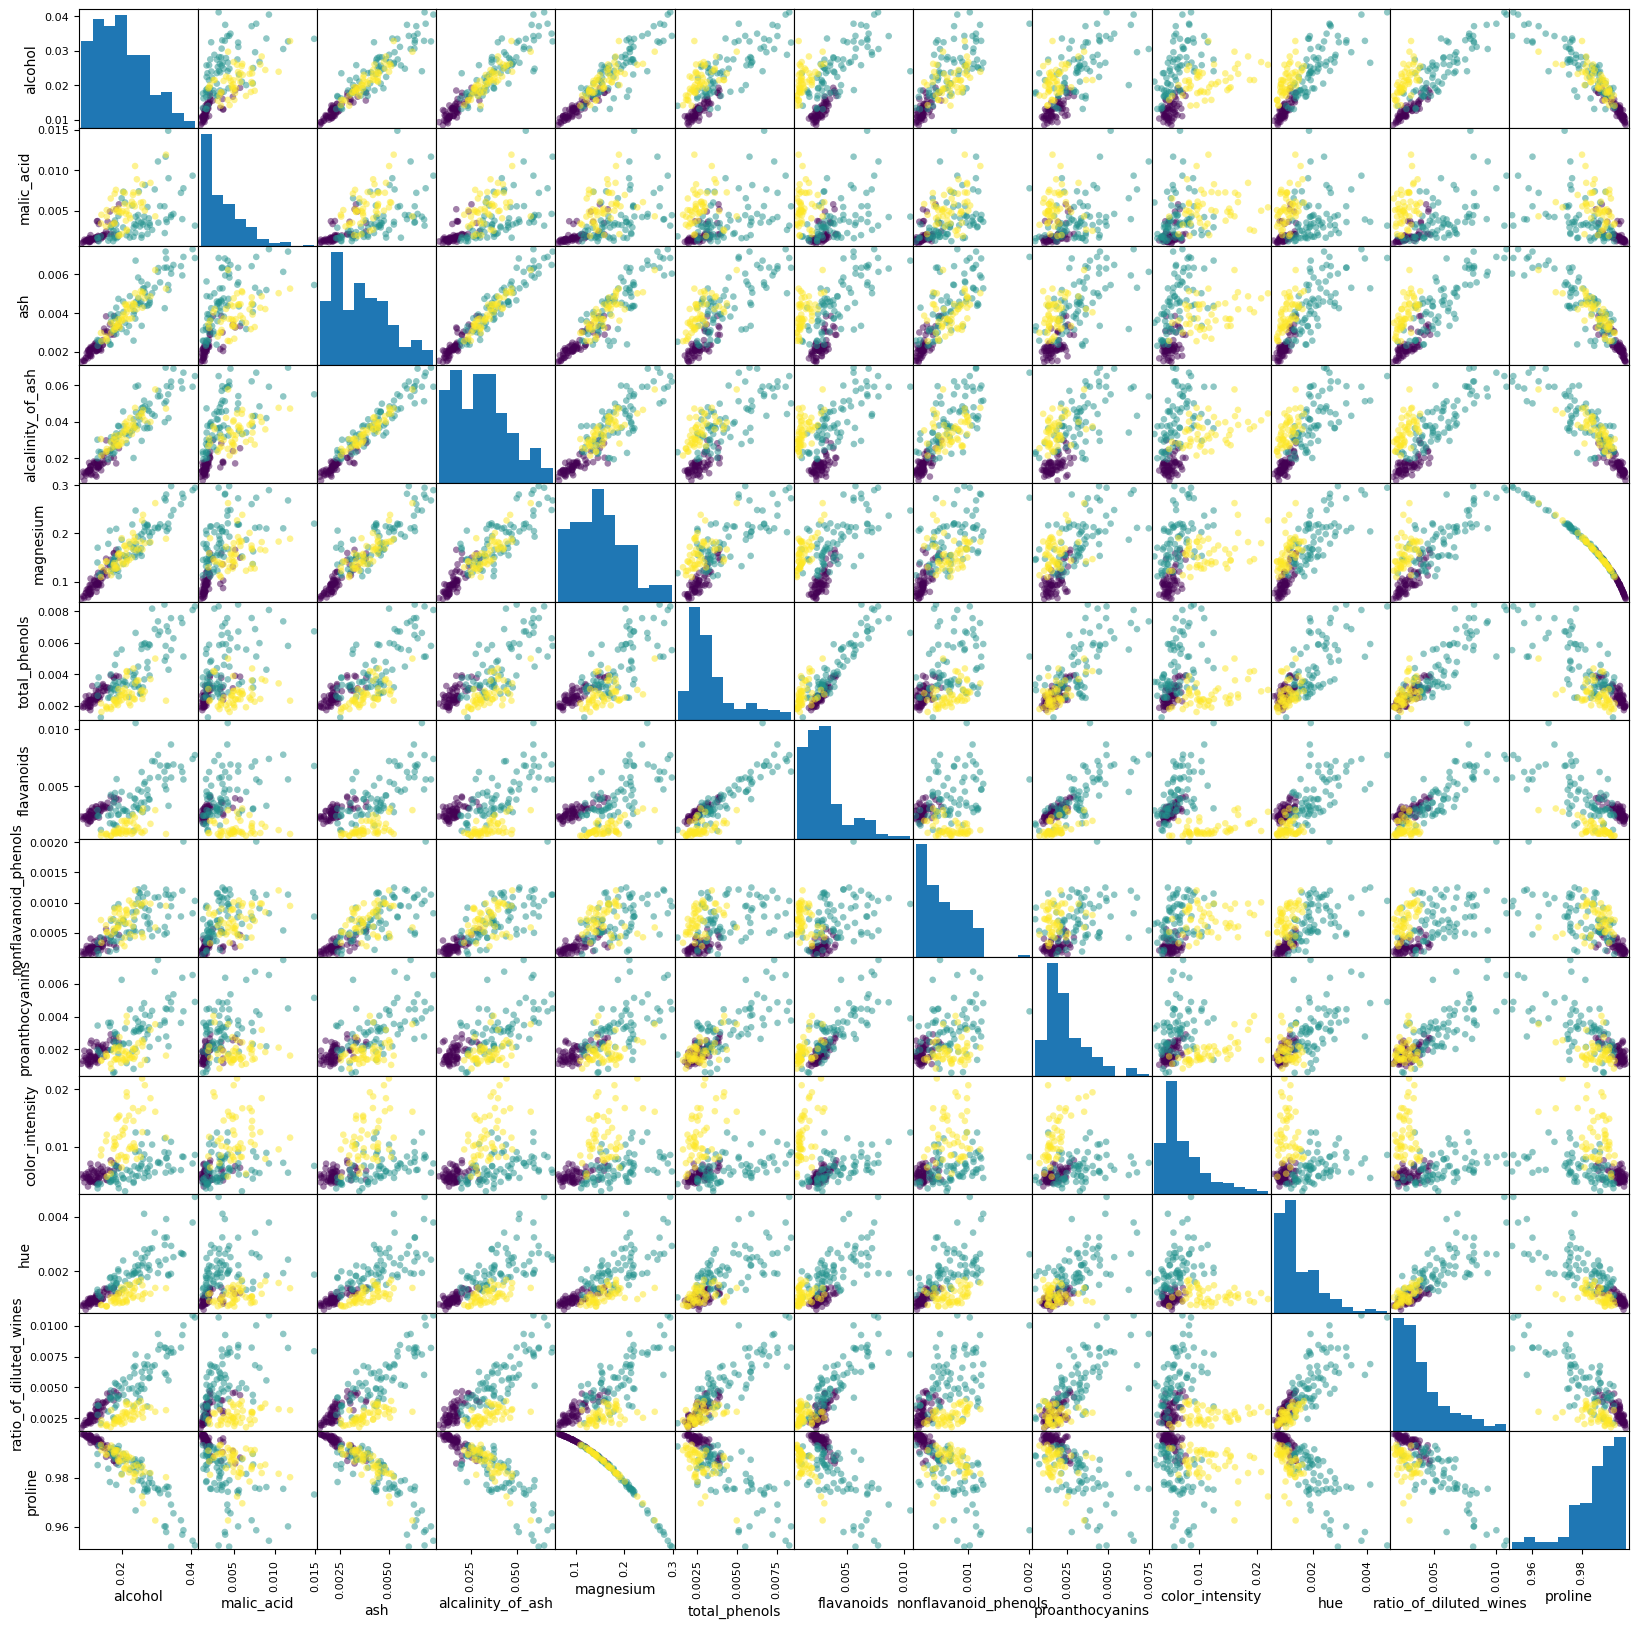

In [15]:
normalized_X = preprocessing.normalize(X)
df_norm = pd.DataFrame(normalized_X, columns=wine.feature_names)
visual_norm = pd.plotting.scatter_matrix(df_norm, figsize=(20, 20), c=Y, s=90)

norm_model = DecisionTreeClassifier(max_depth=4, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X, Y, test_size=0.2)
norm_model.fit(X_train, Y_train)

predictions = norm_model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)
scores = cross_val_score(norm_model, X, Y, cv=10)

print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())
print("Test accuracy:", accuracy)

**Repeated cross-validation to evaluate generalization across multiple random seeds**

In [16]:
normalized_X = preprocessing.scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X, Y, test_size=0.2)
cv_scores = []
for seed in range(5):
    repeated_norm_model = DecisionTreeClassifier(max_depth=4, random_state=seed)
    scores = cross_val_score(repeated_norm_model, X, Y, cv=10)
    cv_scores.append(scores.mean())
    
repeated_norm_model.fit(X_train, Y_train)
cv_scores = np.array(cv_scores)

print("Cross validation values:\n", cv_scores)
print("Cross validation mean:", cv_scores.mean())
print("Cross validation standard deviation: ", cv_scores.std())

Cross validation values:
 [0.87614379 0.86470588 0.86503268 0.87614379 0.85947712]
Cross validation mean: 0.8683006535947712
Cross validation standard deviation:  0.006700541898752494


**QUESTION 2.2.2:**

The scatter matrix above shows the data after normalization. Normalization rescales the data into range of [0, 1] changing the values to a common scale while preserving the relative proportions between features. It is especially helpful when different features have different ranges or units and when we do not want to make assumptions about the underlying distribution of data. 

In [17]:
ros = RandomOverSampler(random_state=0)
X_ros, Y_ros = ros.fit_resample(X,Y)

ros_model = DecisionTreeClassifier(max_depth=4, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_ros, Y_ros, test_size=0.2)
ros_model.fit(X_train, Y_train)

pred_ros = ros_model.predict(X_test)
accuracy = accuracy_score(Y_test, pred_ros)
scores = cross_val_score(ros_model, X_ros, Y_ros, cv=10)

print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())
print("Test accuracy:", accuracy)

Cross validation values:
 [0.90909091 0.77272727 0.95454545 0.9047619  1.         1.
 0.95238095 1.         1.         0.85714286]
Cross validation mean: 0.9350649350649352
Cross validation standard deviation:  0.07180799136530762
Test accuracy: 0.9767441860465116


**Repeated cross-validation to evaluate generalization across multiple random seeds**

In [18]:
ros = RandomOverSampler(random_state=0)
X_ros, Y_ros = ros.fit_resample(X,Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_ros, Y_ros, test_size=0.2)
cv_scores = []
for seed in range(5):
    repeated_ros_model = DecisionTreeClassifier(max_depth=4, random_state=seed)
    scores = cross_val_score(repeated_ros_model, X_ros, Y_ros, cv=10)
    cv_scores.append(scores.mean())
    
repeated_ros_model.fit(X_train, Y_train)
cv_scores = np.array(cv_scores)

print("Cross validation values:\n", cv_scores)
print("Cross validation mean:", cv_scores.mean())
print("Cross validation standard deviation: ", cv_scores.std())

Cross validation values:
 [0.94415584 0.93484848 0.92597403 0.93051948 0.93506494]
Cross validation mean: 0.9341125541125542
Cross validation standard deviation:  0.0060243193229949565


**QUESTION 2.2.3:**

Above shows the data after oversampling. Oversampling creates more data artificially and statistically and is useful when one class in the data is underrepresented. It will generate synthetic samples for the underrepresented class.

In [19]:
rus = RandomUnderSampler(random_state=0)
X_rus, Y_rus = rus.fit_resample(X,Y)

rus_model = DecisionTreeClassifier(max_depth=4, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_rus, Y_rus, test_size=0.2)
rus_model.fit(X_train, Y_train)

pred_rus = rus_model.predict(X_test)
accuracy = accuracy_score(Y_test, pred_rus)
scores = cross_val_score(rus_model, X_rus, Y_rus, cv=10)

print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())
print("Test accuracy:", accuracy)

Cross validation values:
 [0.93333333 0.93333333 0.93333333 0.93333333 1.         1.
 0.92857143 0.92857143 0.92857143 0.92857143]
Cross validation mean: 0.9447619047619048
Cross validation standard deviation:  0.027701027756664727
Test accuracy: 1.0


**Repeated cross-validation to evaluate generalization across multiple random seeds**

In [20]:
rus = RandomUnderSampler(random_state=0)
X_rus, Y_rus = rus.fit_resample(X,Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_rus, Y_rus, test_size=0.2)
cv_scores = []
for seed in range(5):
    repeated_rus_model = DecisionTreeClassifier(max_depth=4, random_state=seed)
    scores = cross_val_score(repeated_rus_model, X_rus, Y_rus, cv=10)
    cv_scores.append(scores.mean())
    
repeated_rus_model.fit(X_train, Y_train)
cv_scores = np.array(cv_scores)

print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())

Cross validation values:
 [0.73333333 0.93333333 0.93333333 0.93333333 0.92857143 1.
 0.92857143 0.92857143 0.92857143 0.92857143]
Cross validation mean: 0.9176190476190476
Cross validation standard deviation:  0.06487560047826123


**QUESTION 2.2.4:**

Above shows the data after undersampling. Undersampling does not use some part of the data and is should be only used when the amount of data is sufficient or when you have too much data for the algorithm to handle. It removes samples from the overrepresented class to reach a balance between the classes. 

In [21]:
rus = RandomUnderSampler(random_state=0)
X_rus, Y_rus = rus.fit_resample(X,Y)

rus_parameter_model = DecisionTreeClassifier(max_depth=4, min_samples_split = 2, min_samples_leaf=4, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_rus, Y_rus, test_size=0.2)
rus_parameter_model.fit(X_train, Y_train)

pred_rus = rus_parameter_model.predict(X_test)
accuracy = accuracy_score(Y_test, pred_rus)
scores = cross_val_score(rus_parameter_model, X_rus, Y_rus, cv=10)

print("Cross validation values:\n", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation standard deviation: ", scores.std())
print("Test accuracy:", accuracy)

Cross validation values:
 [0.86666667 0.86666667 0.93333333 0.93333333 0.92857143 1.
 0.92857143 0.92857143 0.92857143 0.92857143]
Cross validation mean: 0.9242857142857144
Cross validation standard deviation:  0.03553606325105835
Test accuracy: 0.896551724137931


**Repeated cross-validation to evaluate generalization across multiple random seeds**

In [22]:
rus = RandomUnderSampler(random_state=0)
X_rus, Y_rus = rus.fit_resample(X,Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_rus, Y_rus, test_size=0.2)
cv_scores = []
for seed in range(5):
    repeated_rus_parameter_model = DecisionTreeClassifier(max_depth=4, min_samples_split = 2, min_samples_leaf=4, random_state=seed)
    scores = cross_val_score(repeated_rus_parameter_model, X_rus, Y_rus, cv=10)
    cv_scores.append(scores.mean())
    
repeated_rus_parameter_model.fit(X_train, Y_train)
cv_scores = np.array(cv_scores)

print("Cross validation values:\n", cv_scores)
print("Cross validation mean:", cv_scores.mean())
print("Cross validation standard deviation: ", cv_scores.std())

Cross validation values:
 [0.91761905 0.89761905 0.91761905 0.91761905 0.89761905]
Cross validation mean: 0.9096190476190475
Cross validation standard deviation:  0.009797958971132666


**QUESTION 2.3 and 2.4**: 

After testing different methods (standardizing, normalizing, oversampling, undersampling and tuning tree parameters). The following observations were made:

**Standardizing and normalizing**:
- identical in accuracy (0.8594771241830067)
- did not improve performance
- accuracy was lower compared to the combination of tree parameters 

**Oversampling and undersampling**:
- not much difference in accuracy but undersampling is a little more accurate both have CV mean of ~0.93
- improved performance
- higher accuracy compared to standardizing and normalizing of data

**Tree parameters(depth, split, leaf)**:
- limiting depth of tree to prevent overfitting
- ensure minimum number of samples per split and per leaf which helps generalization
  
**Chosen combination for best performance**:
- Oversampling to balance classes and prevent bias
- Decision tree's best combination parameters identified by grid search: `max_depth=4`, `min_samples_split=2`, `min_samples_leaf=4`

This combination provides a balanced dataset while controlling tree complexity. Cross-validation shows that it achieves a good general accuracy 0.924 without overfitting. Standardization or normalization was not included in the combination because it does not improve tree performance, whilst undersampling improves performance and tree parameter tuning gives the best generalization. The model using undersapmling combined with tuned decision tree parameters achieved a mean 10-fold crossvalidation accuracy of 0.924 at best, which is required range of approximately 0.93. This satisfies the assignment's requirement for a general, non-overfitted tree with good generalization performance.

However, to ensure the decision tree generalize well, we repeated 10-fold CV five times with different random seeds. The resulting mean CV accuracy across these repeats was 0.909 with a standard deviation of 0.00979, this slightly drop in mean is due to the variability across random seeds, not worse performance. This low standard deviation indicates that the chosen tree architecture(`max_depth=4`, `min_samples_leaf=4`, `min_samples_split=2`) consistently performs well across different splits of the data, confirming that the model is robust and generalizes beyond a single train/test split. 

Test accuracy: 0.9444444444444444



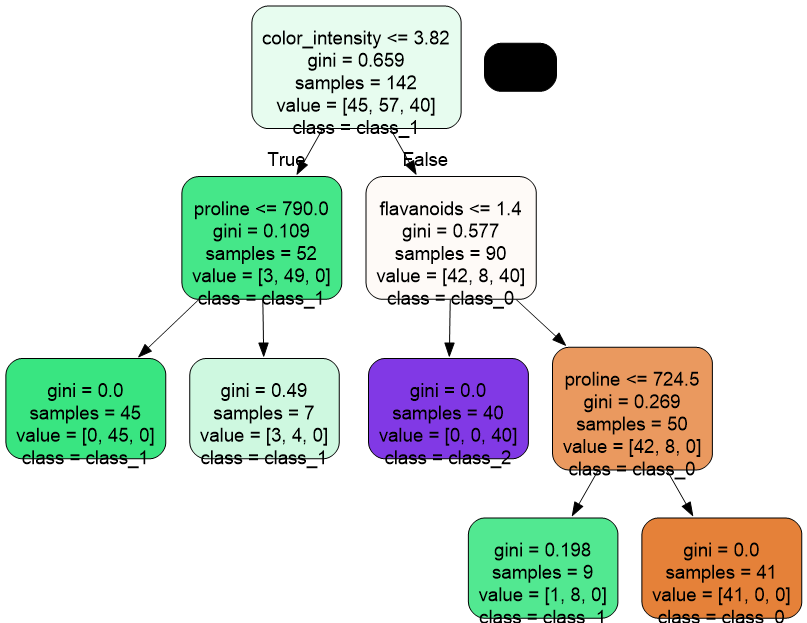

In [23]:
#Beginning of question 2.5
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("Test accuracy:", accuracy)

dot_data = tree.export_graphviz(
    model,
    out_file=None,
    feature_names=wine.feature_names,
    class_names=wine.target_names,
    filled=True,
    rounded=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**Repeated cross-validation to evaluate generalization across multiple random seeds**

In [24]:
#Beginning of question 2.5
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cv_scores = []
for seed in range(5):
    repeated_model = DecisionTreeClassifier(max_depth=4, min_samples_split = 10, min_samples_leaf=4, random_state=seed)
    scores = cross_val_score(repeated_model, X, Y, cv=10)
    cv_scores.append(scores.mean())
    
repeated_model.fit(X_train, Y_train)
cv_scores = np.array(cv_scores)

ValueError: Number of labels=115 does not match number of samples=142

**QUESTION 2.5.1 & 2.5.2:**

The printed value above shows the model's accuracy is aproximately 0.93. And the picture above is the decision tree obtained from the model.

In [ ]:
#Cross-validation test
scores = cross_val_score(model, X, Y, cv=10)
print("Cross-validation mean:", scores.mean())
print("Cross-validation std:", scores.std())

print("REPEATED Cross validation values:\n", cv_scores)
print("REPEATED Cross validation mean:", cv_scores.mean())
print("REPEATED Cross validation standard deviation: ", cv_scores.std())

**QUESTION 2.5.3:**

The mean of the cross validation scores is 0.89 and the standard deviation is 0.082. This was at first a suprising result, for we were expecting a mean of 0.93, however, upon researching, we realized tht this is due to the cross validation tests being run on all the training dat and not just the test data. This issue shows that the model performs well on the particular test split but can be less stable across all possible splits. 

However, to ensure the decision tree generalize well, we repeated 10-fold CV five times with different random seeds. The resulting mean CV accuracy across these repeats was 0.888 with a standard deviation of 0.00614. This low standard deviation indicates that the chosen tree architecture(`max_depth=4`, `min_samples_leaf=4`, `min_samples_split=10`) consistently performs well across different splits of the data, confirming that the model is robust and generalizes beyond a single train/test split.

In [ ]:
#Model's confusion matrix
conf_matrix = pd.crosstab(
    Y_test,
    pred,
    rownames=['Labels'],
    colnames=['Prediction']
)
print(conf_matrix)

**QUESTION 2.5.4:**

The crosstab test allows us to identify possible relations in between data classes that might not be so obvious when simply looking at the whole data set. In this case, our crosstab shows how many data point where correctly predicted from each class, whith the diagonal values indicating the correctly predicted values and the rest of the matrix being the missclassifications.
Seeing as how most of the values are on the diagonal, we can assert that this model has great accuracy and is very consistent, for it only missclassified 2 values out of 36. This could be an explanation of why the CV mean was lower then the accuracy of the model: there might be many more false positives in the whole data set than in the test set.

In [ ]:
#Model's classification report
print(classification_report(y_test, pred, target_names=wine.target_names))

**QUESTION 2.5.5 & 2.5.6:**

The table above is the cross tab report and, considering its values, it does back the results from the cross tabulation. Class_0 has a 93% recall because one of its values is missplaces, and the same happens with class_2, the value difference is because in class_0 the success rate is 13/14 and in class_2 the rate is 7/8.
As for the accuracy values and the avereges, they all coincide with the initial accuracy rate obtained at the beggining of the question, which are the expected values.

On the other hand, the crosstab and the classification report describe the performance of the model on a single test split, which produced an accuracy of 0.94.
In this split, only two misclassifications occurred.However, the cross-validation mean of 0.88 indicates that the tree does not achieve this level of performance across all of the folds. In many of the CV folds, the model probably produces more misclassifications than the two seen in the crosstab report.
This variability, however, explains why the cross-validation accuracy is lower: the tree is sensitive to how the training and test data are partitioned and shows that the model is not perfectly stable.